In [2]:
%matplotlib inline  
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from keras import metrics
import os
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
# from imblearn.keras import BalancedBatchGenerator
# from imblearn.under_sampling import NearMiss
from sklearn.metrics import confusion_matrix

from numpy.random import seed
from tensorflow import set_random_seed
set_random_seed(2)
seed(1)

Using TensorFlow backend.


In [3]:
train_data = pd.read_csv("data/train_data.csv")
test_data = pd.read_csv("data/test_data.csv")
train_labels = pd.read_csv("data/train_labels.csv",header=None).values.reshape(-1)
test_labels = pd.read_csv("data/test_labels.csv",header=None).values.reshape(-1)


model_path = "models/"
img_path = "img/"

In [26]:
train_data.head(5)

,AI552051.754,CYCLE.552051,FI552051_718,FIC552051_718,FQI552051.718,MODSTS.552051,PHASE.552051,PHTIME.552051,PI552051.641,PI552051.642,...,WI552051.674_Bad Input,WI552051.674_I/O Timeout,SIC552051.801_CO_Bad Input,SIC552051.801_CO_I/O Timeout,FI552051_718_Bad Input,FI552051_718_I/O Timeout,FIC552051_718_Bad Input,FIC552051_718_I/O Timeout,FQI552051.718_Bad Input,FQI552051.718_I/O Timeout
0,0.085130,0.0,0.012009,12.009277,208.416672,8.0,21.0,2.698205,0.042778,0.067184,...,0,0,0,0,0,0,0,0,0,0
1,0.085414,0.0,0.012009,12.009277,208.454514,8.0,23.0,2.698218,0.042875,0.067232,...,0,0,0,0,0,0,0,0,0,0
2,0.085697,0.0,0.012009,12.009277,208.492371,8.0,23.0,2.698231,0.041802,0.067184,...,0,0,0,0,0,0,0,0,0,0
3,0.085980,0.0,0.012009,12.009277,208.530212,8.0,23.0,2.698245,0.042720,0.067184,...,0,0,0,0,0,0,0,0,0,0
4,0.086263,0.0,0.012009,12.009277,208.568069,8.0,23.0,2.698258,0.041992,0.067940,...,0,0,0,0,0,0,0,0,0,0


In [7]:
cat_cols = [k for k in list(train_data.columns) if train_data[k].dtype != "float64"]
num_cols = list(set(list(train_data.columns))-set(cat_cols))

# IF MODELS ARE ALREADY CONSTRUCTED YOU CAN ALWAYS RELOAD THEM TO SAVE TIME
models_constructed = False

In [5]:
# Crucial to training this function convers sequential data 
# to "batch data with time_steps" to feed in to LSTM 
def process_sequence(seq,time_steps):
    data = []
    value = []
    i = time_steps
    while i < len(seq):
        data.append(seq[i-time_steps:i])
        value.append(seq[i])
        i+=1
    return np.asarray(data),np.asarray(value)


In [6]:
from keras.optimizers import SGD
from keras.models import load_model
from keras.losses import mean_squared_error,mean_absolute_error, logcosh, categorical_crossentropy, sparse_categorical_crossentropy
from keras.callbacks import TerminateOnNaN, LearningRateScheduler, EarlyStopping

# Early stoppping parameters
cb1 = EarlyStopping(monitor='loss', min_delta=0.0001, patience=3, verbose=0, mode='auto', restore_best_weights=False)
cb2 = TerminateOnNaN()
cb = [cb1,cb2]

    
n_features = 1 # it is a univariate data
n_steps = 6  # 60 mins gives 1 hr



def columnwise_forecast(col):
    
    X,y = process_sequence(train_data[col],n_steps)
    print(X.shape,y.shape)
    n_samples = len(X)
    X = X.reshape(n_samples,n_steps,n_features)
    print(X.shape,y.shape)
    print("Data processed to feed shape ")

    # LSTM Model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss=logcosh)
    
    model.fit(X, y, epochs=1, verbose=1,callbacks=cb)
    tst_X,tst_y = process_sequence(test_data[col],n_steps)
    tst_X = tst_X.reshape(tst_X.shape[0],n_steps,n_features)

    yhat = model.predict(tst_X, verbose=0)
    print("Saving model")
    model.save(model_path+col.replace(".","_")+"_predictor_model.h5")
    del model
    
    return (tst_y,yhat)


In [8]:

modelstore = {}
prediction_store = {}
new_prediction_store = {}

if models_constructed:
    # Load model for each numeric column and store its prediction
    tst_X,tst_y = process_sequence(test_data[col],n_steps)
    tst_X = tst_X.reshape(tst_X.shape[0],n_steps,n_features)
    for col in num_cols:
        mname = model_path+col.replace(".","_")+"_predictor_model.h5"
        if os.path.exists(mname):
            modelstore[col] = load_model(mname)
            print("Loaded model for ",col)
            yhat = modelstore[col].predict(tst_X,verbose=0)
            new_prediction_store[col] = (tst_y,yhat)
else:
    # Construct a fresh set of models for each numeric column
    for col in num_cols:
        print("Model constructed and stored for ",col)
        prediction_store[col] = columnwise_forecast(col)
        

Model constructed and stored for  FI552051_718
(65803, 6) (65803,)
(65803, 6, 1) (65803,)
Data processed to feed shape 
Epoch 1/1
65803/65803 [==============================] - 20s 297us/step - loss: 0.0040
Saving model
Model constructed and stored for  PIN.552051
(65803, 6) (65803,)
(65803, 6, 1) (65803,)
Data processed to feed shape 
Epoch 1/1
65803/65803 [==============================] - 20s 299us/step - loss: 40634.9802
Saving model


In [9]:
def plot_preds_new(tst_y, yhat, col=""):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 15),gridspec_kw={'height_ratios': [1, 5]})
    ax[0].scatter(np.arange(len(test_labels)), [1 for _ in range(len(test_labels))], color="yellow")
    fail_piece = np.where(test_labels[n_steps:] > 0)[0]
    ax[0].scatter(fail_piece, [1 for _ in range(len(fail_piece))], color="red")
    ax[0].set_title("Anomaly distributions over time")

    ax[1].plot(np.arange(len(tst_y)), tst_y, "r--")
    ax[1].plot(np.arange(len(yhat)), yhat, "b--")
    ax[1].set_title("Anomaly distributions over" + str(col))
    ax[1].set_xlabel("Timestamp")
    fig.savefig(img_path+str(col) + "ts_6.png")
    fig.show()


here


/home/venugopal/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


here


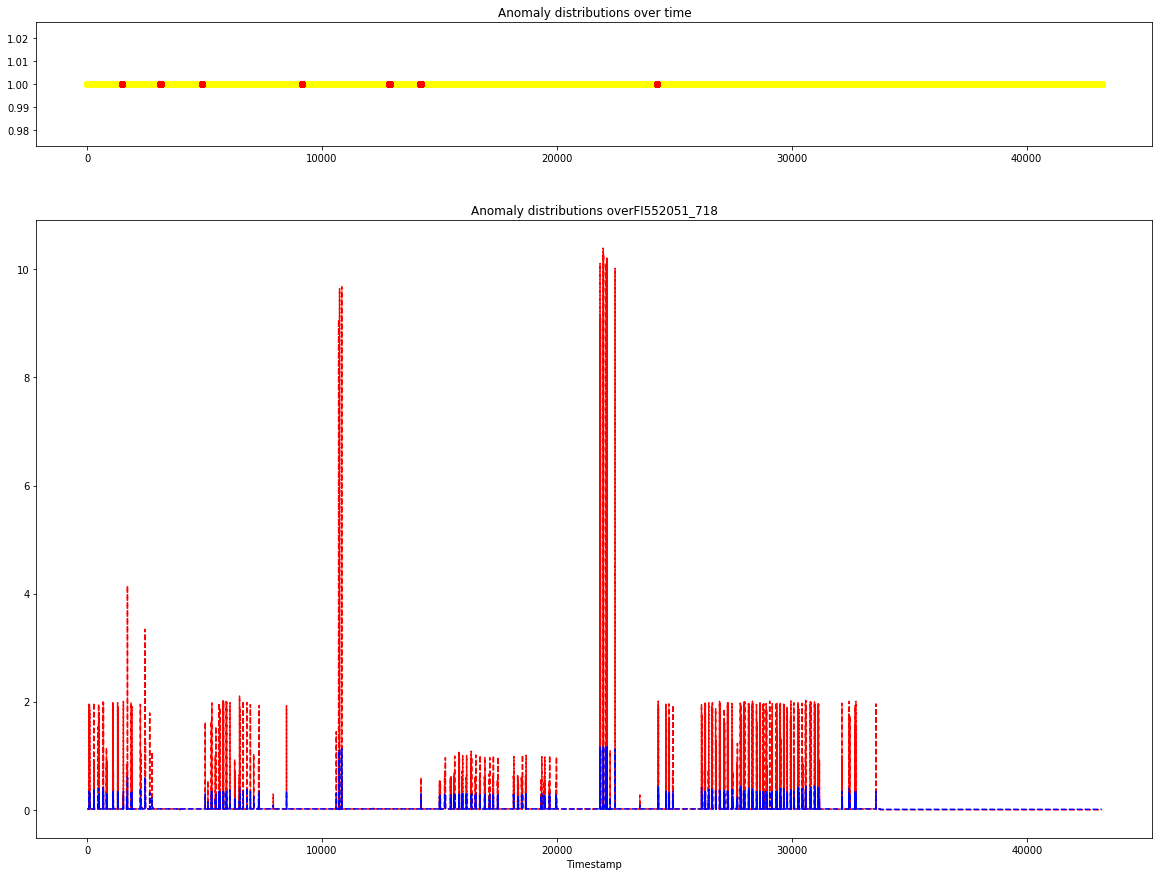

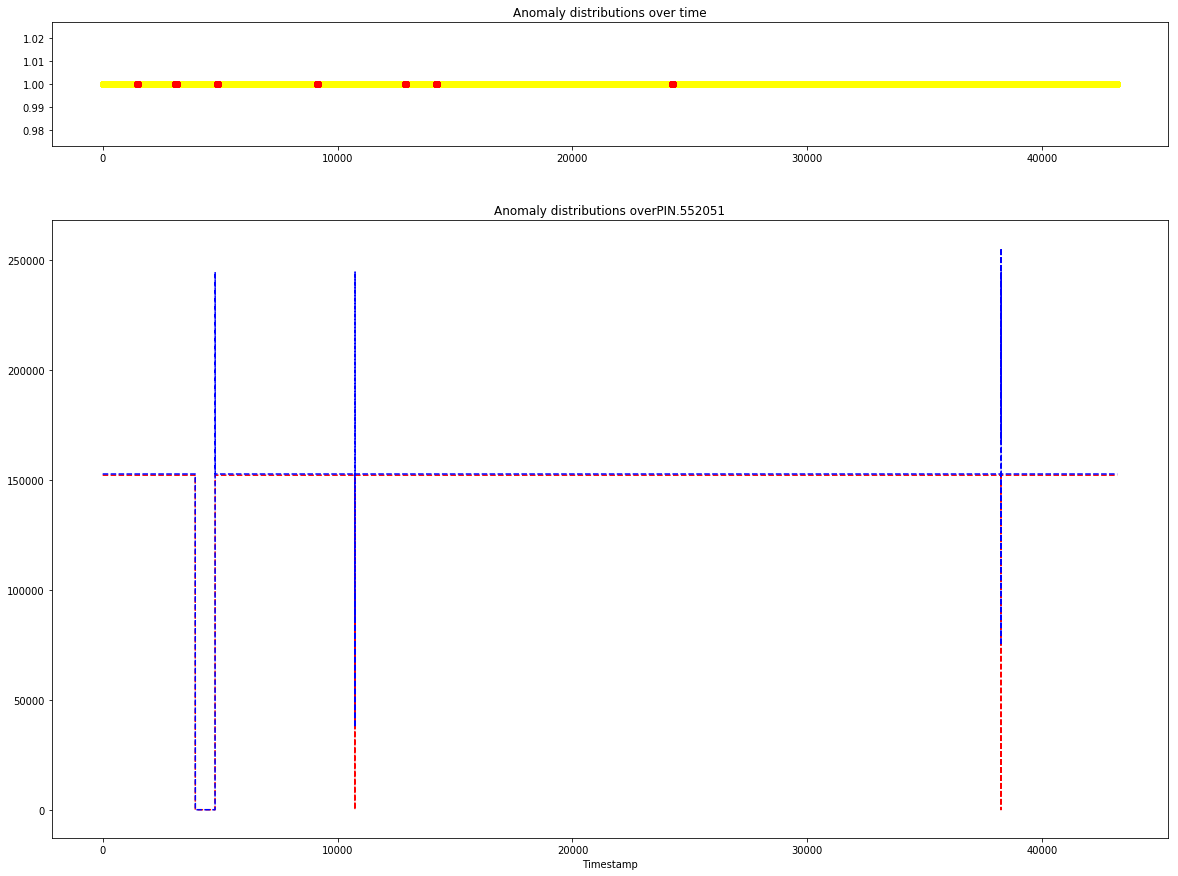

In [10]:
if not models_constructed:
    for k in prediction_store:
        plot_preds_new(prediction_store[k][0],prediction_store[k][1],k)
else:
    for p in new_prediction_store:
        plot_preds_new(new_prediction_store[p][0],new_prediction_store[p][1],p)

In [11]:
def analyze_residuals(prediction_store,test_labels):
    for k in prediction_store:

        yhat = prediction_store[k][1]
        tst_y = prediction_store[k][0]
        residual = np.subtract(yhat.reshape(-1),tst_y)
        print(k ," ----------------------> ")
        print("Min ",np.min(residual)," Max ",np.max(residual)," Mean ",np.mean(residual)," Std ",np.std(residual))

        # Outside of mean
        cur_indices = np.where( (residual > np.mean(residual)) | (residual < np.mean(residual)) )[0]
        cur_indices += n_steps
        print("Outside of mean :",Counter(test_labels[cur_indices]))

        # Oustise of 1-std dev
        cur_indices = np.where( (residual > (np.mean(residual)+np.std(residual))) | (residual < (np.mean(residual)-np.std(residual))) )[0]
        cur_indices += n_steps
        print("Outside of 1 std-dev :",Counter(test_labels[cur_indices]))

        print("\n\n\n")

In [12]:
if not models_constructed:
    analyze_residuals(prediction_store,test_labels)
else:
    analyze_residuals(new_prediction_store,test_labels)

FI552051_718  ----------------------> 
Min  -10.377570738084614  Max  1.1589369773864746  Mean  -0.007375140949270456  Std  0.20624669231316436
Outside of mean : Counter({0: 42963, 2: 189, 1: 43})
Outside of 1 std-dev : Counter({0: 687, 2: 8})




PIN.552051  ----------------------> 
Min  -152167.44207572937  Max  152709.390625  Mean  558.6140711847396  Std  2478.7365181301434
Outside of mean : Counter({0: 42963, 2: 189, 1: 43})
Outside of 1 std-dev : Counter({0: 30})




